## Tensorflow Hub
# Bert
- https://www.tensorflow.org/text/tutorials/classify_text_with_bert
- https://www.tensorflow.org/hub/common_saved_model_apis/text#transformer-encoders
- https://tfhub.dev/google/collections/bert/1 (각종 bert 모듈들)
> 참고 : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4

In [13]:
! pip install tensorflow-text

     |████████████████████████████████| 4.3MB 31.6MB/s 


In [15]:
! pip install -q tf-models-official

     |████████████████████████████████| 1.6MB 32.2MB/s 
     |████████████████████████████████| 38.2MB 79kB/s 
     |████████████████████████████████| 686kB 47.6MB/s 
     |████████████████████████████████| 645kB 49.5MB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
     |████████████████████████████████| 1.2MB 34.0MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 358kB 52.2MB/s 
     |████████████████████████████████| 215kB 57.2MB/s 
     |████████████████████████████████| 102kB 13.7MB/s 


In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [17]:
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

### IMDb 데이터 불러오기

In [2]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

84131840/84125825 [==============================] - 3s 0us/step


In [3]:
! ls -F aclImdb

imdbEr.txt  imdb.vocab	README	test/  train/


In [4]:
! ls -F aclImdb/train

labeledBow.feat  pos/	 unsupBow.feat	urls_pos.txt
neg/		 unsup/  urls_neg.txt	urls_unsup.txt


In [5]:
import os
import shutil

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
train_dir = os.path.join(dataset_dir, 'train')

remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [6]:
AUTOTUNE = tf.data.AUTOTUNE # -1
batch_size = 32
seed = 42

In [7]:
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training', # validation_split 을 사용할때, 학습용 데이터인지 검증용 데이터인지 설정
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [8]:
class_names = raw_train_ds.class_names # ['neg', 'pos']
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [10]:
test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.


In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b"Having seen most of Ringo Lam's films, I can say that this is his best film to date, and the most unusual. It's a ancient china period piece cranked full of kick-ass martial arts, where the location of an underground lair full of traps and dungeons plays as big a part as any of the characters. The action is fantastic, the story is tense and entertaining, and the set design is truely memorable. Sadly, Burning Paradise has not been made available on DVD and vhs is next-to-impossible to get your mitts on, even if you near the second biggest china-town in North America (like I do). If you can find it, don't pass it up."
Label : 1 (pos)
Review: b'Caution: May contain spoilers...<br /><br />I\'ve seen this movie 3 times & I\'ve liked it every time. Upon seeing it again, I\'m always reminded of how good it is. An HBO TV movie- very well done like most of their movies are- this would\'ve gotten Oscars for it\'s performances had it been released for general distribution instead of mad

### 허브 모델 불러오기
- 각 bert 모델 마다 대응되는 전처리 모듈이 존재한다
- PC에 다음과 같이 저장함
> - D:\개발\tfhub\small_bert_bert_en_uncased_L-4_H-512_A-8_1.tar.gz
> - D:\개발\tfhub\bert_en_uncased_preprocess_3.tar.gz

In [11]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [18]:
''' 아래 부분을 실행해야 됨
! pip install tensorflow-text
! pip install -q tf-models-official
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
'''

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

text_test = ['This Is SUCH an amazing movie! 가']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  2023  2003  2107  2019  6429  3185   999  1455 30006   102     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

text_test = ['ha ha', 'ha ha ha']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')
print('')
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][1, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][1, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][1, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (2, 128)
Word Ids   : [ 101 5292 5292  102    0    0    0    0    0    0    0    0]
Input Mask : [1 1 1 1 0 0 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (2, 128)
Word Ids   : [ 101 5292 5292 5292  102    0    0    0    0    0    0    0]
Input Mask : [1 1 1 1 1 0 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


### 모델 실행 테스트

In [20]:
text_test = ['ha ha', 'ha ha ha']

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

bert_results = bert_model(bert_preprocess_model(text_test))

In [ ]:
list(bert_results.keys())

['sequence_output', 'default', 'pooled_output', 'encoder_outputs']

In [ ]:
print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(2, 512)
Pooled Outputs Values:[ 0.9465767   0.7280389   0.362658   -0.16305478 -0.5911153   0.9800556
  0.99936754 -0.8457438  -0.3295367  -0.999554    0.32326624 -0.99259984]
Sequence Outputs Shape:(2, 128, 512)
Sequence Outputs Values:[[ 0.5823476   0.00581039  1.1625923  ... -1.3889809   1.5431125
  -0.12031063]
 [ 0.8191639   0.61655056  0.71007824 ... -0.9502912   1.029787
  -0.32542187]
 [ 0.53549963  0.15783934  0.20947579 ... -0.4272657   0.80537426
   0.22006744]
 ...
 [ 0.45993096 -0.110167    0.2878108  ... -0.68201345  1.1544025
   0.4115017 ]
 [ 0.43089983  0.00748167  0.42543623 ... -0.5958898   1.3870625
  -0.02793963]
 [ 0.21086743  0.11159009  0.6993213  ... -0.63255966  1.36303
  -0.09932029]]


In [ ]:
list(bert_results.keys())

['sequence_output', 'default', 'pooled_output', 'encoder_outputs']

- pooled_output : 한 문장 전체에 대한 결과 [batch_size, H]
- sequence_output : 각 단어별 임베딩 [batch_size, seq_length, H]
- encoder_outputs : Transformer 블록의 중간 활성화

### 전이학습

In [21]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)

net = outputs['pooled_output']
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)

classifier_model = tf.keras.Model(text_input, net)

In [22]:
text_test = ['ha ha', 'ha ha ha']

bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor(
[[0.39467934]
 [0.34660766]], shape=(2, 1), dtype=float32)


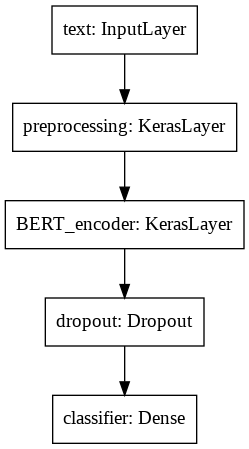

In [23]:
tf.keras.utils.plot_model(classifier_model)

In [24]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True) # from_logits=True 이므로, sigmoid 함수를 적용할 필요가 없음
metrics = tf.metrics.BinaryAccuracy()

미세 조정을 위해 BERT가 원래 훈련 된 것과 동일한 최적화 프로그램 인 "Adaptive Moments"(Adam)를 사용하겠습니다. 이 옵티마이 저는 예측 손실을 최소화하고 AdamW 라고도 알려진 가중치 감소 (모멘트를 사용하지 않음)로 정규화를 수행 합니다.
<br><br>

학습률 ( init_lr )의 경우 BERT 사전 학습과 동일한 일정을 사용합니다. 즉, 학습 단계의 처음 10 % ( num_warmup_steps )에 걸쳐 선형 워밍업 단계가 접두사로 붙은 개념적 초기 학습률의 선형 감쇠입니다. BERT 논문에 따르면 미세 조정의 경우 초기 학습률이 더 낮습니다 (5e-5, 3e-5, 2e-5 중 최고).

In [25]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy() # 20000 개 훈련데이터가 배치크기 32로 분리됨
print(steps_per_epoch) # 625 = 20000/32

625


In [28]:
num_train_steps = steps_per_epoch * epochs # 625*5
num_warmup_steps = int(0.1*num_train_steps) # 312

init_lr = 3e-5
# from official.nlp import optimization  # to create AdamW optimizer
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [29]:
optimizer

In [30]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [31]:
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Epoch 1/5
625/625 [==============================] - 164s 253ms/step - loss: 0.4820 - binary_accuracy: 0.7451 - val_loss: 0.3891 - val_binary_accuracy: 0.8046
Epoch 2/5
625/625 [==============================] - 154s 246ms/step - loss: 0.3283 - binary_accuracy: 0.8526 - val_loss: 0.3848 - val_binary_accuracy: 0.8304
Epoch 3/5
625/625 [==============================] - 154s 246ms/step - loss: 0.2514 - binary_accuracy: 0.8942 - val_loss: 0.4070 - val_binary_accuracy: 0.8362
Epoch 4/5
625/625 [==============================] - 159s 254ms/step - loss: 0.1920 - binary_accuracy: 0.9230 - val_loss: 0.4337 - val_binary_accuracy: 0.8514
Epoch 5/5
625/625 [==============================] - 154s 247ms/step - loss: 0.1503 - binary_accuracy: 0.9434 - val_loss: 0.4896 - val_binary_accuracy: 0.8514


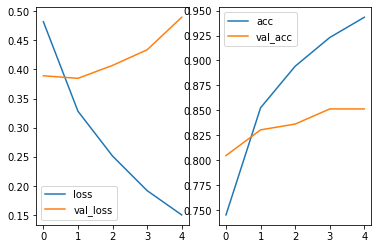

In [32]:
h = history.history

plt.subplot(1,2,1)
plt.plot(h['loss'])
plt.plot(h['val_loss'])
plt.legend(['loss', 'val_loss'])

plt.subplot(1,2,2)
plt.plot(h['binary_accuracy'])
plt.plot(h['val_binary_accuracy'])
plt.legend(['acc', 'val_acc'])

In [33]:
loss, acc = classifier_model.evaluate(test_ds)
loss, acc

782/782 [==============================] - 86s 110ms/step - loss: 0.4574 - binary_accuracy: 0.8562


(0.4574122726917267, 0.8562399744987488)

### 모델 저장

In [38]:
classifier_model.save('imdb_bert_model', include_optimizer=False)
! ls -F

aclImdb/		  imdb_bert_model/    model.png
aclImdb_v1.tar.gz.tar.gz  imdb_bert_model.h5  sample_data/


In [40]:
! tar cvzf imdb_bert_model.tar.gz imdb_bert_model

imdb_bert_model/
imdb_bert_model/variables/
imdb_bert_model/variables/variables.index
imdb_bert_model/variables/variables.data-00000-of-00001
imdb_bert_model/saved_model.pb
imdb_bert_model/keras_metadata.pb
imdb_bert_model/assets/
imdb_bert_model/assets/vocab.txt


In [42]:
from google.colab import files
files.download('aclImdb_v1.tar.gz.tar.gz')
files.download('imdb_bert_model.tar.gz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
reloaded_model = tf.saved_model.load('imdb_bert_model')
reloaded_model

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fd3a3aeb110>

In [44]:
classifier_model

In [45]:
examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

In [47]:
tf.sigmoid(reloaded_model(tf.constant(examples)))

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[9.9951935e-01],
       [9.9587655e-01],
       [8.7700254e-01],
       [3.3292666e-02],
       [9.6644950e-04]], dtype=float32)>

In [48]:
tf.sigmoid(classifier_model(tf.constant(examples)))

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[9.9951935e-01],
       [9.9587655e-01],
       [8.7700254e-01],
       [3.3292666e-02],
       [9.6644950e-04]], dtype=float32)>